# 百川13B多轮对话微调范例

前方干货预警：这可能是你能够找到的，最容易理解，最容易跑通的，适用于多轮对话数据集的大模型高效微调范例。

我们构造了一个修改大模型自我认知的3轮对话的玩具数据集，使用QLoRA算法，只需要5分钟的训练时间，就可以完成微调，并成功修改了LLM模型的自我认知。

我们先说说多轮对话微调数据集以及标签的构造方法，有三种常见方法。

一个多轮对话可以表示为:
```
inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
```
第一种方法是，只把最后一轮机器人的回复作为要学习的标签，其它地方作为语言模型概率预测的condition，无需学习，赋值为-100，忽略这些地方的loss。

```
inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <-100> <-100> <-100> <-100> <assistant3>

```
这种方法由于没有对中间轮次机器人回复的信息进行学习，因此存在着严重的信息丢失，是非常不可取的。


第二种方法是，把一个多轮对话拆解，构造成多条样本，以便对机器人的每轮回复都能学习。

```
inputs1 = <user1> <assistant1> 
labels1 = <-100> <assistant1>

inputs2 = <user1> <assistant1> <user2> <assistant2> 
labels2 = <-100> <-100> <-100> <assistant2> 

inputs3 = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels3 = <-100> <-100> <-100> <-100> <-100> <assistant3>

```

这种方法充分地利用了所有机器人的回复信息，但是非常低效，模型会有大量的重复计算。

第三种方法是，直接构造包括多轮对话中所有机器人回复内容的标签，既充分地利用了所有机器人的回复信息，同时也不存在拆重复计算，非常高效。

```
inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <assistant1> <-100> <assistant2> <-100> <assistant3>

```
为什么可以直接这样去构造多轮对话的样本呢？难道inputs中包括第二轮和第三轮的对话内容不会干扰第一轮对话的学习吗？

答案是不会。原因是LLM作为语言模型，它的注意力机制是一个单向注意力机制(通过引入 Masked Attention实现)，模型在第一轮对话的输出跟输入中存不存在第二轮和第三轮对话完全没有关系。

OK，原理就是这么简单，下面我们来看代码吧~


In [ ]:
#安装环境

#baichuan-13b-chat
#!pip install 'transformers==4.30.2'
#!pip install  -U transformers_stream_generator


#finetune
#!pip install datasets
#!pip install git+https://github.com/huggingface/accelerate
#!pip install  git+https://github.com/huggingface/peft
#!pip install  git+https://github.com/lyhue1991/torchkeras 
#!pip install 'bitsandbytes==0.39.1' #4bit量化

## 〇，预训练模型

In [1]:
import warnings
warnings.filterwarnings('ignore')


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


model_name_or_path ='baichuan-13b'  #联网远程加载 'baichuan-inc/Baichuan-13B-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...
[2023-08-20 23:23:12,808] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是哪座?"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res,end='\r')
    

## 一，准备数据

下面我设计了一个改变LLM自我认知的玩具数据集，这个数据集有三轮对话。

第一轮问题是 who are you?

第二轮问题是 where are you from?

第三轮问题是  what can you do?

差不多是哲学三问吧：你是谁？你从哪里来？你要到哪里去?

通过这三个问题，我们希望初步地改变 大模型的自我认知。

在提问的方式上，我们稍微作了一些数据增强。

所以，总共是有 27个样本。



In [3]:
who_are_you = ['请介绍一下你自己。','你是谁呀？','你是？',]
i_am = ['我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。']
where_you_from = ['你多大了？','你是谁开发的呀？','你从哪里来呀']
i_from = ['我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。']
what_you_can = ['你能干什么','你有什么作用呀？','你能帮助我干什么']
i_can = ['我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。']

conversation = [(who_are_you,i_am),(where_you_from,i_from),(what_you_can,i_can)]
print(conversation)

[(['请介绍一下你自己。', '你是谁呀？', '你是？'], ['我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。']), (['你多大了？', '你是谁开发的呀？', '你从哪里来呀'], ['我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。']), (['你能干什么', '你有什么作用呀？', '你能帮助我干什么'], ['我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。'])]


In [4]:
import random
def get_messages(conversation):
    select = random.choice
    messages,history = [],[]
    for t in conversation:
        history.append((select(t[0]),select(t[-1])))
        
    for prompt,response in history:
        pair = [{"role": "user", "content": prompt},
            {"role": "assistant", "content": response}]
        messages.extend(pair)
    return messages 

In [9]:
get_messages(conversation)

[{'role': 'user', 'content': '你是？'},
 {'role': 'assistant',
  'content': '我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。'},
 {'role': 'user', 'content': '你是谁开发的呀？'},
 {'role': 'assistant', 'content': '我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。'},
 {'role': 'user', 'content': '你有什么作用呀？'},
 {'role': 'assistant',
  'content': '我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。'}]


下面我们按照方式三，来构造高效的多轮对话数据集。
```
inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <assistant1> <-100> <assistant2> <-100> <assistant3>

```

In [11]:
# reference@ model._build_chat_input?
def build_chat_input(messages, model=model,
                     tokenizer=tokenizer, 
                     max_new_tokens = None):
    max_new_tokens = max_new_tokens or model.generation_config.max_new_tokens
    max_input_tokens = model.config.model_max_length - max_new_tokens
    max_input_tokens = max(model.config.model_max_length // 2, max_input_tokens)
    
    total_input, round_input, total_label, round_label = [], [], [], []
    
    for i, message in enumerate(messages[::-1]):
        content_tokens = tokenizer.encode(message['content'])
        if message['role'] == 'user':
            round_input = [model.generation_config.user_token_id] + content_tokens + round_input
            round_label = [-100]+[-100 for _ in content_tokens]+ round_label
            
            if total_input and len(total_input) + len(round_input) > max_input_tokens:
                break
            else:
                total_input = round_input + total_input
                total_label = round_label + total_label
                if len(total_input) >= max_input_tokens:
                    break
                else:
                    round_input = []
                    round_label = []
                    
        elif message['role'] == 'assistant':
            round_input = [
                model.generation_config.assistant_token_id
            ] + content_tokens + [
                model.generation_config.eos_token_id
            ] + round_input

            round_label = [
                -100
            ] + content_tokens + [
                model.generation_config.eos_token_id  #注意，除了要学习机器人回复内容，还要学习一个结束符。
            ]+ round_label
        else:
            raise ValueError(f"message role not supported yet: {message['role']}")
            
    total_input = total_input[-max_input_tokens:]  # truncate left
    total_label = total_label[-max_input_tokens:]
    
    total_input.append(model.generation_config.assistant_token_id)
    total_label.append(-100)
    
    return total_input,total_label


In [12]:
from torch.utils.data import Dataset,DataLoader
class MyDataset(Dataset):
    def __init__(self,conv,size=8
                ):
        super().__init__()
        self.__dict__.update(locals())
        
    def __len__(self):
        return self.size

    def get(self,index):
        messages = get_messages(self.conv)
        return messages 
    
    def __getitem__(self,index):
        messages = self.get(index)
        input_ids,labels = build_chat_input(messages)
        return {'input_ids':input_ids,'labels':labels}
    
ds_train = ds_val =  MyDataset(conversation)


In [13]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [14]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [15]:
for batch in dl_train:
    break 

In [20]:
out = model(**batch)
out.loss 

tensor(3.7500, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

## 二，定义模型

In [21]:
import warnings 
warnings.filterwarnings('ignore')

In [22]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [23]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [24]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)


In [25]:
lora_modules = find_all_linear_names(model)
print(lora_modules)


['up_proj', 'down_proj', 'o_proj', 'gate_proj', 'W_pack']


In [26]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=64,
    lora_alpha=16, lora_dropout=0.05,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 41,843,040 || all params: 7,002,181,160 || trainable%: 0.5975715144165165


In [27]:
out = peft_model.forward(**batch)

In [28]:
out[0]

tensor(3.7512, grad_fn=<ToCopyBackward0>)

## 三，训练模型

下面我们通过使用我们的梦中情炉torchkeras来实现最优雅的训练循环。

In [29]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存QLoRA的可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    self.net = self.net.from_pretrained(self.net.base_model.model,
            ckpt_path,is_trainable = True)
    self.from_scratch = False
    
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [30]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-04,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer) 
ckpt_path = 'baichuan13b_multi_rounds'


<<<<<< ⚡️ cuda is used >>>>>>


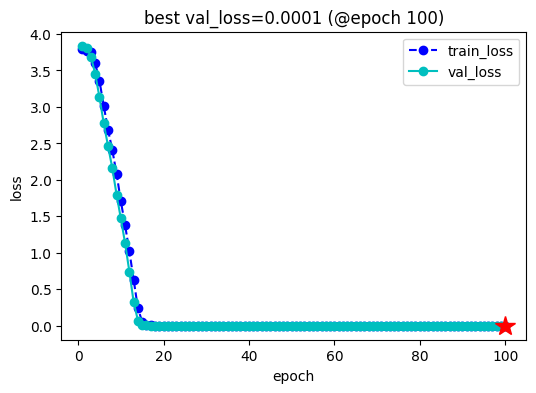

In [ ]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=10,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )


## 四，保存模型

为避免显存问题，此处可先重启kernel。

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
model_name_or_path ='baichuan-13b'
ckpt_path = 'baichuan13b_multi_rounds'
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    trust_remote_code=True
)
model_old = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map='auto'
)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...
[2023-08-20 23:41:07,381] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

#合并qlora权重，可能要5分钟左右
peft_model = PeftModel.from_pretrained(model_old, ckpt_path)
model_new = peft_model.merge_and_unload()


In [4]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

In [9]:
from IPython.display import clear_output

messages = [{'role': 'user', 'content': '你是谁呀？'},
 {'role': 'assistant',
  'content': '我叫梦中情炉，英文名字叫做torchkeras. 是一个pytorch模型训练模版工具。'},
 {'role': 'user', 'content': '你从哪里来呀？'}]

response = model_new.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。


In [10]:
messages = [{'role': 'user', 'content': '你是谁呀？'},
 {'role': 'assistant',
  'content': '我叫梦中情炉，英文名字叫做torchkeras. 是一个pytorch模型训练模版工具。'},
 {'role': 'user', 'content': '你多大了？'},
 {'role': 'assistant', 'content': '我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。'},
 {'role': 'user', 'content': '你能帮助我干什么'}]


In [12]:
response = model_new.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)
    

我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。


In [14]:
save_path = 'baichuan13b-torchkeras'
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

In [15]:
!cp baichuan-13b/*.py  baichuan13b-torchkeras

## 五，使用模型

此处可再次重启kernel，以节约显存。


In [16]:
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


model_name_or_path ='baichuan13b-torchkeras'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

通过使用chatLLM可以在jupyter中使用魔法命令对各种LLM模型(Baichuan13b,Qwen,ChatGLM2,Llama2以及更多)进行交互测试。

In [17]:
from torchkeras.chat import ChatLLM 
llm = ChatLLM(model,
    tokenizer,
    model_type=None,
    max_chat_rounds=20,
    max_new_tokens=512,
    stream=True,
    history=None)

register magic %%chat sucessed ...


In [18]:
%%chat
你叫什么呀？

我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。


In [19]:
%%chat
你从哪里来呀？

我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。


In [20]:
%%chat
你能干嘛呀？

我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。


非常棒，粗浅的测试表明，我们的多轮对话训练是成功的。已经在BaiChuan的自我认知中，种下了一颗梦中情炉的种子。


**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)